<a href="https://colab.research.google.com/github/keran-w/3d-deep-learning/blob/main/pointnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pointnet Example

**Reference:** https://github.com/nikitakaraevv/pointnet

### Load Dataset from Kaggle

In [2]:
# use github private repo in colab
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive', force_remount=True)
clear_output()

Mounted at /content/drive


In [3]:
import os
DOWNLOAD = False

if DOWNLOAD:
  # add kaggle token from drive
  if not os.path.isfile('~/.kaggle/kaggle.json'):
    os.system('mkdir ~/.kaggle')
    os.system('cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json')

  # download and unzip kaggle dataset
  !kaggle datasets download -d balraj98/modelnet40-princeton-3d-object-dataset
  !unzip modelnet40-princeton-3d-object-dataset.zip -d .
  clear_output()

## EDA

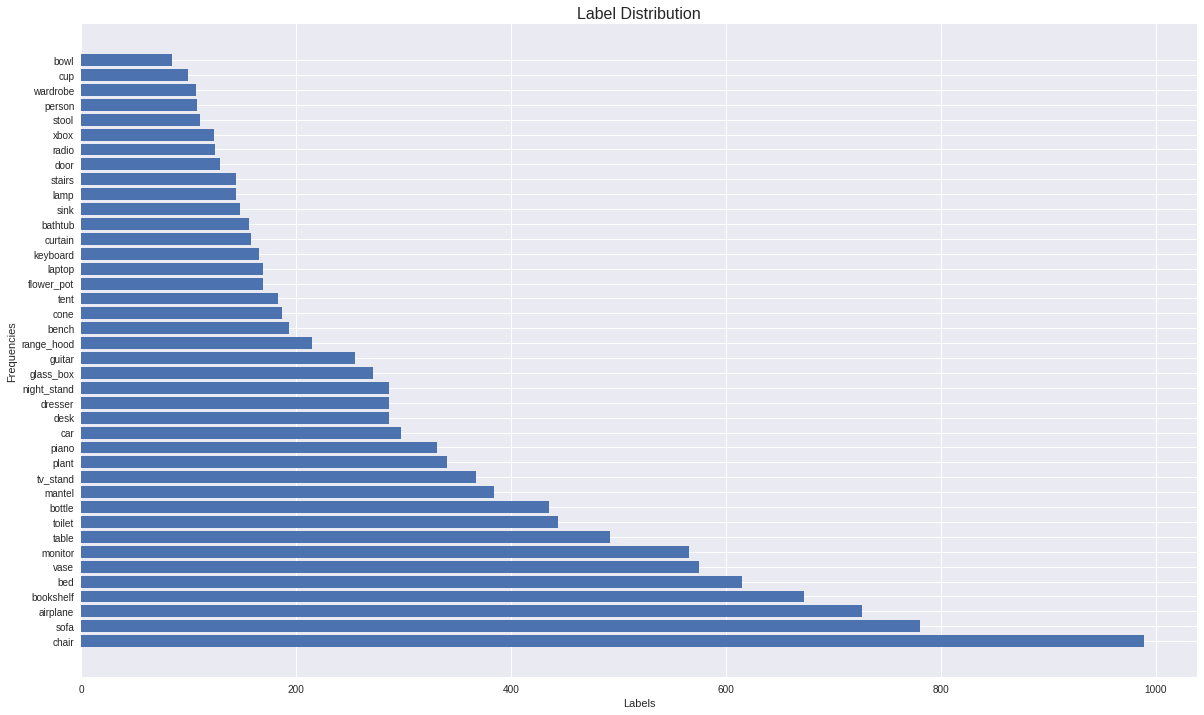

In [31]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')


# get all labels and label distribution
dataset_dir = "./ModelNet40"
labels = sorted(os.listdir(dataset_dir))

label_distribution = {
    label:len(
        os.listdir(f'{dataset_dir}/{label}/train') +
        os.listdir(f'{dataset_dir}/{label}/test')
        ) for label in labels
}
label_distribution = dict(sorted(label_distribution.items(), key=lambda item: item[1], reverse=True))


fig, ax = plt.subplots(figsize=(20, 12))
ax.barh(list(label_distribution.keys()),
         list(label_distribution.values())
)
ax.set_xlabel('Labels')
ax.set_ylabel('Frequencies')
ax.set_title('Label Distribution', fontsize=16)
plt.show()

# Data Loading and Visualization

In [46]:
# read in data
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

# read a sample model
sample_label = 'bed'
with open(f'{dataset_dir}/{sample_label}/train/{sample_label}_0001.off', 'r') as f:
  verts, faces = read_off(f)

In [47]:
import numpy as np
# visualize a model
import plotly.graph_objects as go
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

i,j,k = np.array(faces).T
x,y,z = np.array(verts).T
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i,j=j,k=k)]).show()

In [51]:
import random
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

# visualize point cloud
pointcloud = PointSampler(3000)((verts, faces))
pcshow(*pointcloud.T)

In [52]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

# visualize point cloud with normalization
norm_pointcloud = Normalize()(pointcloud)
pcshow(*norm_pointcloud.T)

# Data Augmentation

In [55]:
import math
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud
# add rotation (the model retains the same after rotation)
rot_pointcloud = RandRotation_z()(norm_pointcloud)
# with small noise, the model classification wouldn't be changed
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

# visualize point cloud with augmentation
pcshow(*noisy_rot_pointcloud.T)

# Create Dataset

In [63]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        return torch.from_numpy(pointcloud)

default_transform = transforms.Compose([
  PointSampler(1024),
  Normalize(),
  ToTensor()
])

class PointCloudData(Dataset):
    def __init__(self, dataset_dir, valid=False, folder="train", transform=default_transform):
        self.dataset_dir = dataset_dir
        folders = [dir for dir in sorted(os.listdir(dataset_dir)) if os.path.isdir(f'{dataset_dir}/{dir}')]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transform
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = f'{dataset_dir}/{category}/{folder}'
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = f'{new_dir}/{file}'
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [66]:
train_transform = transforms.Compose([
  PointSampler(1024),
  Normalize(),
  RandRotation_z(),
  RandomNoise(),
  ToTensor()
])

# get train set and valid set
train_set = PointCloudData(dataset_dir, transform=train_transform)
valid_set = PointCloudData(dataset_dir, valid=True, folder='test', transform=train_transform)

inv_classes = {i: cat for cat, i in train_set.classes.items()};
print('Train dataset size: ', len(train_set))
print('Valid dataset size: ', len(valid_set))
print('Number of classes: ', len(train_set.classes))
print('Sample pointcloud shape: ', train_set[0]['pointcloud'].size())
print('Class: ', inv_classes[train_set[0]['category']])

Train dataset size:  9843
Valid dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  airplane


In [67]:
# get loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=32)

# Model

In [69]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

## Train

In [74]:
# get training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

# initialize model, optimizer and loss function
pointnet = PointNet().to(device)
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

Training on cpu


In [ ]:
def train(model, train_loader, valid_loader=None, epochs=5, save=False):
    if save:
        os.mkdir('saved_models', exist_ok=True)
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    
                # print every 10 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                      (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

    pointnet.eval()
    correct = total = 0

    # validation
    if valid_loader:
      with torch.no_grad():
          for data in valid_loader:
              inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
              outputs, __, __ = pointnet(inputs.transpose(1,2))
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
              val_acc = 100. * correct / total
          print('Valid accuracy: %d %%' % val_acc)

    # save the model
    if save:
        torch.save(pointnet.state_dict(), f'./saved_models/save_{epoch}.pth')

train(pointnet, train_loader, valid_loader, save=False)